In [3]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt

## Data Loading

In [4]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
test_img = []
train_labels = [] #label of each image in x_train 
test_labels = []
TRAIN_PATH = '../input/brain-tumor-classification-mri/Training'
TEST_PATH = '../input/brain-tumor-classification-mri/Testing'
new_size = (255, 255)

for label in labels:
    img_dir = os.path.join(TRAIN_PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        img = cv2.resize(img, new_size)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255
        train_img.append(img)
        train_labels.append(label)
        
train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)
print("train_labels shape : ", train_labels.shape)

for label in labels:
    img_dir = os.path.join(TEST_PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        img = cv2.resize(img, new_size)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)/255
        test_img.append(img)
        test_labels.append(label)
        
test_img = np.stack(test_img)
test_labels = np.stack(test_labels)

print("test_img shape : ", test_img.shape)
print("test_labels shape : ", test_labels.shape)

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])
test_labels = np.array([class_map[label] for label in test_labels])

train_img shape :  (2870, 255, 255)
train_labels shape :  (2870,)
test_img shape :  (394, 255, 255)
test_labels shape :  (394,)


## Data pre-processing

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA

train_img = train_img.reshape((train_img.shape[0], 255*255))
test_img = test_img.reshape((test_img.shape[0], 255*255))
S = StandardScaler()
X_train = S.fit_transform(train_img)
X_test = S.transform(test_img)
P = PCA(n_components = 100)
pca_train = P.fit_transform(X_train)
pca_test = P.transform(X_test)

In [6]:
data_train = np.hstack((pca_train, train_labels[:,None]))
data_test = np.hstack((pca_test, test_labels[:,None]))

all_data = np.vstack((data_train, data_test))
X = all_data[:,:-1]
y = all_data[:,-1]

# C4.5/J48

Testing the Decision Tree Classifier (CART / C4.5) and computing metrics with different hyperparameters

In [7]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_validate, cross_val_score

In [8]:
def C45(X, y, max_depth, criterion= "gini"):
    
    for depth in max_depth:
    
        clf = DecisionTreeClassifier(max_depth = depth, criterion = criterion)
        #clf = clf.fit(X, y)
        #y_pred = clf.predict(pca_test)
        #tn, fp, fn, tp = confusion_matrix(test_labels, y_pred)
        acc = cross_val_score(clf, X, y, cv=10).mean()
        precision = cross_val_score(clf, X, y, cv=10, scoring='precision_weighted').mean()
        recall = cross_val_score(clf, X, y, cv=10, scoring='recall_weighted').mean()
        f1 = cross_val_score(clf, X, y, cv=10, scoring='f1_weighted').mean()
        roc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovr_weighted').mean()
        
        
        print(f'\n max_depth {depth}, criterion {criterion}')
        print("10-fold Accuracy = ", acc)
        print("10-fold Precision = ", precision)
        print("10-fold Recall = ", recall)
        print("10-fold f1-score = ", f1)
        print("10-fold roc score = ", roc)
        

In [9]:
C45(X, y, max_depth = [5, 10, 20, 50, 100])


 max_depth 5, criterion gini
10-fold Accuracy =  0.6157942627718054
10-fold Precision =  0.6228150544429486
10-fold Recall =  0.6157952008405095
10-fold f1-score =  0.6015813367722401
10-fold roc score =  0.8200583250832952

 max_depth 10, criterion gini
10-fold Accuracy =  0.7169133787358586
10-fold Precision =  0.7140065789990608
10-fold Recall =  0.7153852648167952
10-fold f1-score =  0.7142006955996495
10-fold roc score =  0.8300799159774908

 max_depth 20, criterion gini
10-fold Accuracy =  0.7273259413519446
10-fold Precision =  0.7355834353818687
10-fold Recall =  0.730384983396184
10-fold f1-score =  0.7274498620400129
10-fold roc score =  0.811347489714235

 max_depth 50, criterion gini
10-fold Accuracy =  0.7319337348267386
10-fold Precision =  0.7352498613611497
10-fold Recall =  0.7291758128365321
10-fold f1-score =  0.7263668538283163
10-fold roc score =  0.8203342638604383

 max_depth 100, criterion gini
10-fold Accuracy =  0.7233391493592991
10-fold Precision =  0.73757

Accuracy increases with max_depth.
However, evolution of accuracy and other metrics between max_depth = 20 and max_depth=100 is not significant.

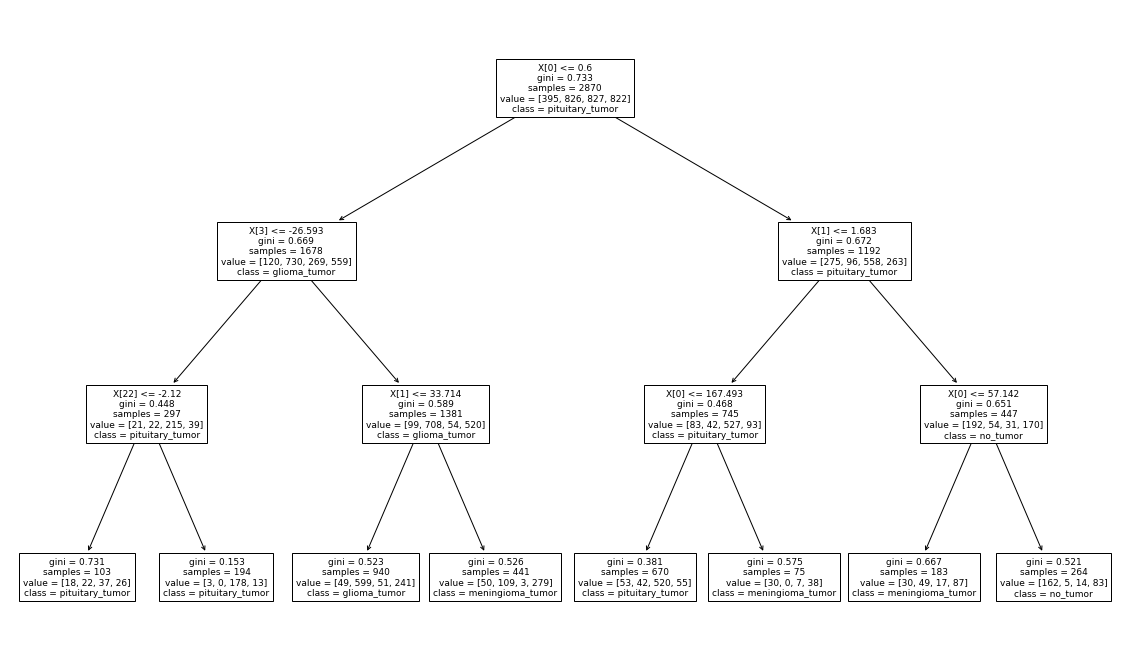

In [10]:
# Plotting a decision tree with max_depth = 3

clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(pca_train, train_labels)

plt.figure(figsize=(20,12))
sklearn.tree.plot_tree(clf, class_names = list(class_map.keys()), fontsize=9)
plt.show()

Gini tends to decrease at each expansion (correct behavior is gini = 0) but it is not necesarily always true, which is not optimal. This not optimal behavior is reflected in the "value" attribute of each node, where there is often no predominant class.

## OTHER HYPERPARAMETERS TO INVESTIGATE (for tree size reduction)

- other splitting criteria than "gini" (Gini impurity) --> see random forest section
- min_samples_leaf (by default = 1)
- (eventually) min_impurity_decrease (e.g. splitting only if it induces impurity decrease greater or equal to threshold)
- ccp_alpha : prunes (removes branches) the tree. Greater is ccp_alpha, smaller the resulting tree is (e.g. more nodes are pruned)

### Complexity Cost Pruning (CCP alpha)

Pruning the tree $T$ to minimize :
$$R_{\alpha}(T) = R(T) + \alpha |\tilde{T}|$$
Where $R(T)$ is the weighted impurity (see splitting criterion) and $\tilde{T}$ is the number of terminal nodes in $T$. 
The more we increase $\alpha$, the more we prune $T$

In [11]:
ccp_alphas = np.linspace(0, 0.05, 20)
clfs = []
for alpha in ccp_alphas:
    DT = DecisionTreeClassifier(max_depth = 50, ccp_alpha = alpha)
    DT.fit(pca_train, train_labels)
    clfs.append(DT)

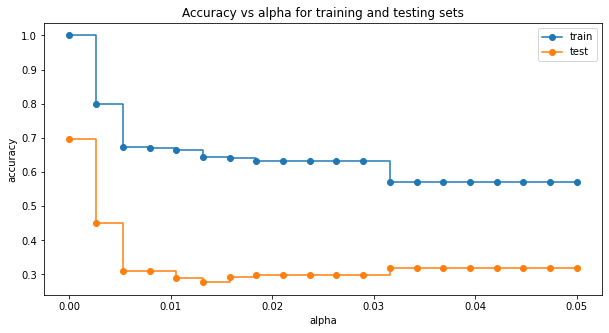

In [12]:
train_scores = [clf.score(pca_train, train_labels) for clf in clfs]
test_scores = [clf.score(pca_test, test_labels) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Explicit overfitting as the first step demonstrates 100% accuracy on the training set but only 70% on testing set (reflected in 10 fold cross validation). CCP alpha pruning, however, makes the accuracy worst on both training and testing sets. Pruning isn't effective in preventing overfitting.

## Splitting Criteria

Sklearn notably disposes of two splitting criteria (or impurities) : Gini and Entropy.


To calculate Gini and Entropy impurities at node m, given that we have n classes :
$$ \forall k \in \{1, ... n\},$$
$$\ p_{mk} = \frac{\Bigl|\Bigl\{sample \ | \ sample \in \ m, sample \ class = k\Bigr\}\Bigr|}{\Bigl|\Bigl\{sample \ | \ sample \in \ m \Bigr\}\Bigr|} $$
$$ Gini(m) = \sum_{k=1}^{n} p_{mk}(1 - p_{mk})$$
$$Entropy(m) = -\sum_{k=1}^{n} p_{mk}log(p_{mk})$$

A feature and a threshold can be selected according to the minimization of these impurities.
As results with Gini criterion have already been computed, we do it with the Entropy one this time

In [13]:
# testing Entropy criterion

C45(X, y, max_depth = [5, 10, 20, 50, 100], criterion = "entropy")


 max_depth 5, criterion entropy
10-fold Accuracy =  0.6271326991988894
10-fold Precision =  0.6339835800467276
10-fold Recall =  0.6268268888013357
10-fold f1-score =  0.6186101068789261
10-fold roc score =  0.8332778568809376

 max_depth 10, criterion entropy
10-fold Accuracy =  0.7242668993077054
10-fold Precision =  0.7348318363253484
10-fold Recall =  0.7184471210671469
10-fold f1-score =  0.7202980848839202
10-fold roc score =  0.8362225408368543

 max_depth 20, criterion entropy
10-fold Accuracy =  0.7346982232978744
10-fold Precision =  0.7485689112084891
10-fold Recall =  0.7383745145494456
10-fold f1-score =  0.7352337143089243
10-fold roc score =  0.820694944447208

 max_depth 50, criterion entropy
10-fold Accuracy =  0.7374533310819685
10-fold Precision =  0.7384190892105513
10-fold Recall =  0.7383726384120373
10-fold f1-score =  0.7367716831487193
10-fold roc score =  0.8244231751064189

 max_depth 100, criterion entropy
10-fold Accuracy =  0.7356231590401681
10-fold Prec

Results a little worse than with Gini impurity criterion. Moreover, some overfitting seems to happen with max depth past 50.

## Minimum samples per leaf

Self explanatory

In [14]:
min_samp = np.linspace(1, 100, 20).astype('int')
clfs = []
for m in min_samp:
    DT = DecisionTreeClassifier(max_depth = 50, min_samples_leaf = m)
    DT.fit(pca_train, train_labels)
    clfs.append(DT)

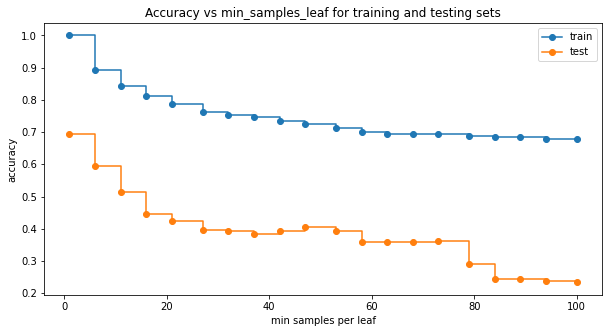

In [15]:
train_scores = [clf.score(pca_train, train_labels) for clf in clfs]
test_scores = [clf.score(pca_test, test_labels) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("min samples per leaf")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs min_samples_leaf for training and testing sets")
ax.plot(min_samp, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(min_samp, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Increasing the minimum number of samples per leaf makes the accuracy worse both on the training and testing sets. There is moreover no overfitting reducing.

## Minimum impurity decrease

A node will be split if the resulting impurity decreases more than this hyperparameter value (min_impurity_decrease).

In [16]:
imp = np.linspace(0, 0.05, 20)
clfs = []
for m in imp:
    DT = DecisionTreeClassifier(max_depth = 50, min_impurity_decrease = m)
    DT.fit(pca_train, train_labels)
    clfs.append(DT)

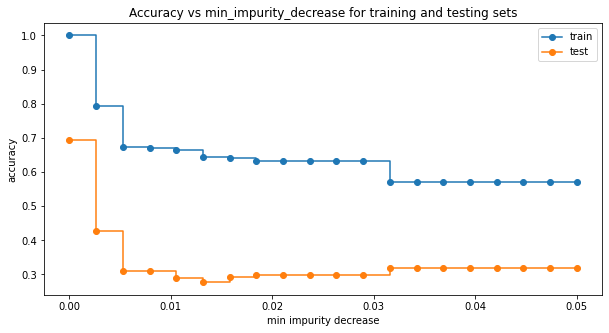

In [17]:
train_scores = [clf.score(pca_train, train_labels) for clf in clfs]
test_scores = [clf.score(pca_test, test_labels) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("min impurity decrease")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs min_impurity_decrease for training and testing sets")
ax.plot(imp, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(imp, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Global decrease of accuracy on training and testing sets as the minimum impurity increases.

## Grid Search for optimal hyperparameters

WARNING : CAN TAKE SOME TIME (~3-5min)

In [18]:
from sklearn.model_selection import GridSearchCV

DT = DecisionTreeClassifier()
criterion = ('gini', 'entropy')
max_depth = np.linspace(1, 101, 3).astype('int')
min_samples_leaf = np.linspace(1, 101, 3).astype('int')
min_impurity_decrease = np.linspace(0, 0.05, 3)
ccp_alpha = np.linspace(0, 0.05, 3)
parameters = {'criterion': criterion, 'max_depth' : max_depth, 'min_samples_leaf':min_samples_leaf, 'min_impurity_decrease':min_impurity_decrease, 'ccp_alpha':ccp_alpha}
clf = GridSearchCV(DT, parameters, cv=10)
clf.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.   , 0.025, 0.05 ]),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': array([  1,  51, 101]),
                         'min_impurity_decrease': array([0.   , 0.025, 0.05 ]),
                         'min_samples_leaf': array([  1,  51, 101])})

In [19]:
print("best params : ", clf.best_params_)
print("best score = ", clf.best_score_)

best params :  {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 51, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1}
best score =  0.7371456445470066


Tree size hyperparameters don't help increasing the classifier's accuracy. Eventually max_depth can be fixed at 50.

## RandomizedSearchCV for Optimizing  hyperparameters

Faster than GridSearchCV because not all parameter values are tried out.

In [20]:
from sklearn.model_selection import RandomizedSearchCV

DT = DecisionTreeClassifier()
criterion = ('gini', 'entropy')
max_depth = np.linspace(1, 101, 3).astype('int')
min_samples_leaf = np.linspace(1, 101, 3).astype('int')
min_impurity_decrease = np.linspace(0, 0.05, 3)
ccp_alpha = np.linspace(0, 0.05, 3)
parameters = {'criterion': criterion, 'max_depth' : max_depth, 'min_samples_leaf':min_samples_leaf, 'min_impurity_decrease':min_impurity_decrease, 'ccp_alpha':ccp_alpha}
clf = RandomizedSearchCV(DT, parameters, cv=10)
clf.fit(X, y)


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'ccp_alpha': array([0.   , 0.025, 0.05 ]),
                                        'criterion': ('gini', 'entropy'),
                                        'max_depth': array([  1,  51, 101]),
                                        'min_impurity_decrease': array([0.   , 0.025, 0.05 ]),
                                        'min_samples_leaf': array([  1,  51, 101])})

In [21]:
print("best params : ", clf.best_params_)
print("best score = ", clf.best_score_)

best params :  {'min_samples_leaf': 51, 'min_impurity_decrease': 0.0, 'max_depth': 51, 'criterion': 'entropy', 'ccp_alpha': 0.025}
best score =  0.5741186844524493


## Tree 1
With the best working parameters from the randomized search.

In [22]:
DT = DecisionTreeClassifier(max_depth = 51, min_impurity_decrease = 0.025, criterion='entropy', ccp_alpha=0.0, min_samples_leaf=101)
clf = DT.fit(pca_train, train_labels)

DT2 = DecisionTreeClassifier(max_depth = 101, min_impurity_decrease = 0.0, criterion='gini', ccp_alpha=0.0, min_samples_leaf=1)
clf2 = DT2.fit(pca_train, train_labels)

In [23]:
train_scores = clf2.score(pca_train, train_labels)
test_scores = clf2.score(pca_test, test_labels) 

print("\n Grid Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

train_scores = clf.score(pca_train, train_labels)
test_scores = clf.score(pca_test, test_labels) 

print("\n Random Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")


 Grid Search CV
Training Accuracy...1.0
Test Accuracy...0.6878172588832487

 Random Search CV
Training Accuracy...0.6498257839721254
Test Accuracy...0.2893401015228426


The decision tree does not generalize well to new data. The test accuracy is way lower than the training accuracy.

## Tree 2
Moving 30% of the training samples to the testing set.

In [24]:
from sklearn.model_selection import train_test_split

x_train_30, x_test_30, y_train_30, y_test_30 = train_test_split(pca_train, train_labels, test_size=0.30, random_state=42)

new_test_data = np.hstack((x_test_30, y_test_30[:,None]))

all_test_data = np.vstack((new_test_data, data_test))
x_test_30 = all_test_data[:,:-1]
y_test_30 = all_test_data[:,-1]

In [25]:
clf = DT.fit(x_train_30, y_train_30)
clf2 = DT2.fit(x_train_30, y_train_30)

In [26]:
train_scores = clf2.score(x_train_30, y_train_30)
test_scores = clf2.score(x_test_30, y_test_30) 

print("\n Grid Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

train_scores = clf.score(x_train_30, y_train_30)
test_scores = clf.score(x_test_30, y_test_30) 

print("\n Random Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")


 Grid Search CV
Training Accuracy...1.0
Test Accuracy...0.6693227091633466

 Random Search CV
Training Accuracy...0.6480836236933798
Test Accuracy...0.4956175298804781


## Tree 3

Moving 60% of the training samples to the testing set.


In [27]:
from sklearn.model_selection import train_test_split

x_train_60, x_test_60, y_train_60, y_test_60 = train_test_split(pca_train, train_labels, test_size=0.60, random_state=42)

new_test_data = np.hstack((x_test_60, y_test_60[:,None]))

all_test_data = np.vstack((new_test_data, data_test))
x_test_60 = all_test_data[:,:-1]
y_test_60 = all_test_data[:,-1]

In [28]:
clf = DT.fit(x_train_60, y_train_60)
clf2 = DT2.fit(x_train_60, y_train_60)

In [29]:
train_scores = clf2.score(x_train_60, y_train_60)
test_scores = clf2.score(x_test_60, y_test_60) 

print("\n Grid Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

train_scores = clf.score(x_train_60, y_train_60)
test_scores = clf.score(x_test_60, y_test_60)  

print("\n Random Search CV")
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")


 Grid Search CV
Training Accuracy...1.0
Test Accuracy...0.6016068052930057

 Random Search CV
Training Accuracy...0.6437282229965157
Test Accuracy...0.5600189035916824


## Resume table

TODO

In [30]:
# Evaluation Buffers
hyperparam = ["gini max_depth 20", 
              "gini max_depth 50", 
              "gini max_depth 100", 
              "entropy max_depth 50", 
              "min_impurity_decrease 0.02",
              "min_impurity_decrease 0.05", 
              "min_samples_leaf 10", 
              "min_samples_leaf 20", 
              "ccp_alpha 0.02",  
              "ccp_alpha 0.05"]
Acc = []
Pr = []
Rec = []
F1 = [] 
AUC = []

def evaluator(X, y, max_depth = [None], criterion= ["gini"], impurity_dec = [0.0], leaf_samples = [1], ccp_alphas = [0.0]):
    for depth in max_depth:
        for crit in criterion:
            for mid in impurity_dec:
                for ls in leaf_samples:
                    for ccp in ccp_alphas:
                        clf = DecisionTreeClassifier(max_depth = depth, criterion = crit, min_impurity_decrease=mid, min_samples_leaf = ls, ccp_alpha=ccp)
                        acc = cross_val_score(clf, X, y, cv=10).mean()
                        precision = cross_val_score(clf, X, y, cv=10, scoring='precision_weighted').mean()
                        recall = cross_val_score(clf, X, y, cv=10, scoring='recall_weighted').mean()
                        f1 = cross_val_score(clf, X, y, cv=10, scoring='f1_weighted').mean()
                        roc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovr_weighted').mean()
                        Acc.append(acc)
                        Pr.append(precision)
                        Rec.append(recall)
                        F1.append(f1)
                        AUC.append(roc)

In [31]:
evaluator(X,y, max_depth = [20, 50, 100])
evaluator(X,y,max_depth = [50], criterion = ["entropy"])
evaluator(X,y,max_depth = [50], impurity_dec = [0.02, 0.05])
evaluator(X,y,max_depth = [50], leaf_samples = [10, 20])
evaluator(X,y,max_depth = [50], ccp_alphas = [0.02, 0.05])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

In [32]:
data = {'Hyperparameter': hyperparam,
        'Accuracy' : Acc,
        'Weighted Precision': Pr,
        'Weighted Recall' : Rec,
        'Weighted F1 Score' : F1,
        'Weighted AUC' : AUC
        }
pd.set_option('expand_frame_repr', False)
resume = pd.DataFrame(data)

print(resume)

               Hyperparameter  Accuracy  Weighted Precision  Weighted Recall  Weighted F1 Score  Weighted AUC
0           gini max_depth 20  0.723037            0.738814         0.728258           0.721188      0.812168
1           gini max_depth 50  0.721196            0.738742         0.734681           0.734139      0.814361
2          gini max_depth 100  0.727022            0.738201         0.718128           0.726819      0.814422
3        entropy max_depth 50  0.734696            0.744998         0.735299           0.729963      0.822820
4  min_impurity_decrease 0.02  0.521126            0.536755         0.521126           0.498931      0.721648
5  min_impurity_decrease 0.05  0.440856            0.272396         0.440856           0.331093      0.634494
6         min_samples_leaf 10  0.676757            0.683503         0.678287           0.674082      0.856026
7         min_samples_leaf 20  0.638462            0.646521         0.637849           0.635133      0.849441
8         

## Random forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
def randomForest(X, y, n = 100, crit = 'gini', max_depth = 1):
    
    clf = RandomForestClassifier(n_estimators = n, criterion = crit, max_depth = max_depth)
    clf.fit(X, y)

    acc = cross_val_score(clf, X, y, cv=10).mean()
    precision = cross_val_score(clf, X, y, cv=10, scoring='precision_weighted').mean()
    recall = cross_val_score(clf, X, y, cv=10, scoring='recall_weighted').mean()
    f1 = cross_val_score(clf, X, y, cv=10, scoring='f1_weighted').mean()
    roc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovr_weighted').mean()

#     print(f'\n max_depth {max_depth}, criterion {crit}')
#     print("10-fold Accuracy = ", acc)
#     print("10-fold Precision = ", precision)
#     print("10-fold Recall = ", recall)
#     print("10-fold f1-score = ", f1)
#     print("10-fold roc score = ", roc)

    return acc, precision, recall, f1, roc

### Warning: extremly long run

In [35]:
from tabulate import tabulate

estimators = [10, 20]
criterions = ['gini', 'entropy']
depth = [5, 10, 20]


for crit in criterions:
    print(f"\nUsing criterion {crit}:")
    lines = [["max_depth \ n_estimators"] + estimators]
    
    for dep in depth:
        lines.append([f"\n max_depth: {dep}"])
        
        for esti in estimators:
            acc, precision, recall, f1, roc = randomForest(X, y, esti, crit, dep)
            lines[-1].append(f"accuracy: {acc}\n precision: {precision}\n recall: {recall}\n f1: {f1}\n roc: {roc}")
            
            
    print(tabulate(lines))
    


Using criterion gini:
------------------------  ------------------------------  ------------------------------
max_depth \ n_estimators  10                              20
max_depth: 5              accuracy: 0.6663552278568883    accuracy: 0.6887319187257275
                           precision: 0.6764591868847034   precision: 0.6947230527894573
                           recall: 0.6638946736458979      recall: 0.6881034126939457
                           f1: 0.6537663852988717          f1: 0.6704270667697158
                           roc: 0.8769256676590789         roc: 0.8960190441059309
max_depth: 10             accuracy: 0.7815538170015571    accuracy: 0.8164696722387947
                           precision: 0.7914807410505825   precision: 0.8046290036020333
                           recall: 0.7815491266580364      recall: 0.7922881371831674
                           f1: 0.784972132094228           f1: 0.7972533363783664
                           roc: 0.9329349096740678      

## RandomizedSearchCV for Optimizing RandomForests  hyperparameters

In [36]:
from sklearn.model_selection import RandomizedSearchCV

DT = RandomForestClassifier()
n_estimators = np.linspace(10, 50, 100).astype('int')
criterion = ('gini', 'entropy')
max_depth = np.linspace(1, 101, 3).astype('int')
min_samples_leaf = np.linspace(1, 101, 3).astype('int')
min_impurity_decrease = np.linspace(0, 0.05, 3)
ccp_alpha = np.linspace(0, 0.05, 3)
parameters = {'criterion': criterion, 'max_depth' : max_depth, 'min_samples_leaf':min_samples_leaf, 'min_impurity_decrease':min_impurity_decrease, 'ccp_alpha':ccp_alpha}
clf = RandomizedSearchCV(DT, parameters, cv=10)
clf.fit(X, y)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'ccp_alpha': array([0.   , 0.025, 0.05 ]),
                                        'criterion': ('gini', 'entropy'),
                                        'max_depth': array([  1,  51, 101]),
                                        'min_impurity_decrease': array([0.   , 0.025, 0.05 ]),
                                        'min_samples_leaf': array([  1,  51, 101])})

In [37]:
print("best params : ", clf.best_params_)
print("best score = ", clf.best_score_)

best params :  {'min_samples_leaf': 51, 'min_impurity_decrease': 0.0, 'max_depth': 101, 'criterion': 'entropy', 'ccp_alpha': 0.025}
best score =  0.5965019418022176


## Tree 1 (RandomForest)

In [38]:
DT = RandomForestClassifier(max_depth = 101, min_impurity_decrease = 0.0, criterion='gini', ccp_alpha=0.0, min_samples_leaf=1)
clf = DT.fit(pca_train, train_labels)

In [39]:
train_scores = clf.score(pca_train, train_labels)
test_scores = clf.score(pca_test, test_labels) 
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

Training Accuracy...1.0
Test Accuracy...0.7411167512690355


## Tree 2 (RandomForest)

In [40]:
clf = DT.fit(x_train_30, y_train_30)

In [41]:
train_scores = clf.score(x_train_30, y_train_30)
test_scores = clf.score(x_test_30, y_test_30) 
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

Training Accuracy...1.0
Test Accuracy...0.7872509960159363


## Tree 3 (RandomForest)

In [42]:
clf = DT.fit(x_train_60, y_train_60)

In [43]:
train_scores = clf.score(x_train_60, y_train_60)
test_scores = clf.score(x_test_60, y_test_60) 
print(f"Training Accuracy...{train_scores}")
print(f"Test Accuracy...{test_scores}")

Training Accuracy...1.0
Test Accuracy...0.7396030245746692
